data shape:  (901, 64)
class shape:  (901,)
Computing t-SNE embedding


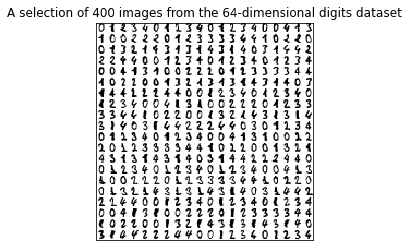

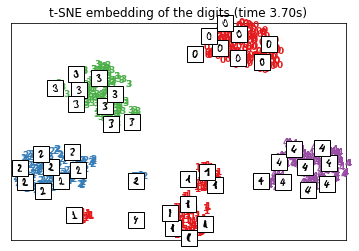

In [6]:
# Step 1: Load data and visualize using TSNE
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 
import matplotlib.image as mimage
from time import time
import numpy as np
from matplotlib import offsetbox


# Utilities function: scale and visualize the embedding vectors. You don't have to touch this function.
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)


# load digits dataset with 5 classes. The dataset has 10 classes in total, so you can add more 
# amount of data as you like.
digits = load_digits(n_class=5)
X = digits.data
y = digits.target
n_samples, n_features = X.shape

print("data shape: ",X.shape)
print("class shape: ",y.shape)

# plot some images of the digits
n_img_per_row = 20
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))

plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('A selection of 400 images from the 64-dimensional digits dataset')

# visualize by groups with TSNE
print("Computing t-SNE embedding")
tsne = TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
# note: if the error "t-SNE fails with array must not contain infs or NaNs" shown, just update numpy by:
# conda install numpy
# fix: https://github.com/scikit-learn/scikit-learn/issues/6665
X_tsne = tsne.fit_transform(X)

plot_embedding(X_tsne,
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))

plt.show()

# Optional: There are many techniques to reduce data dimensionality for visualization. You can try PCA as introduced in
# the lecture.

In [7]:
# Step 2: Implement k-means. In this step, you are provided the function for calculating distances between two matrices.
# and you will implement k-means algorithm. The algorithm returns cluster labels of your data and the centroids of these
# clusters.

# This function calculates the pair-wise distances between all pairs of rows between two matrices A and B
# Note: don't forget the exercise on vectorized implementation
# Inputs: 
#   A: a matrix of size n x d
#   B: a matrix of size m x d
# Output:
#   D: a distance matrix of size n x m
def euclidean_vectorized(A, B):   
    n, d = A.shape
    m, d1 = B.shape
    assert d == d1, 'Incompatible shape'
    A_squared = np.sum(np.square(A), axis=1, keepdims=True)
    B_squared = np.sum(np.square(B), axis=1, keepdims=True)
    AB = np.matmul(A, B.T)
    distances = np.sqrt(A_squared - 2 * AB + B_squared.T)
    return distances

    
### The kmeans clustering function
# X: data matrix of size (n_samples,n_features)
# n_clusters: number of clusters
# output 1: labels of X with size (n_samples,)
# output 2: centroids of clusters
def kmeans(X,n_clusters):
    # initialize labels and prev_labels. prev_labels will be compared with labels to check if the stopping condition
    # have been reached.
    prev_labels = np.zeros(X.shape[0])
    labels = np.zeros(X.shape[0])
    
    # init random indices
    indices = np.random.choice(X.shape[0], n_clusters, replace=False)# np.random.permutation(X.shape[0])[:n_clusters]
    
    # assign centroids using the indices created in the previous step
    centroids = X[indices]
    
    # the interative algorithm goes here
    while (True):
        # calculate the distances between all data points (in X) to the current centroids
        # YOUR CODE GOES HERE
        distances = euclidean_vectorized(X, centroids)
        
        # assign all data points to the centroids 
        labels = np.argmin(distances, axis=1)
        
        # stopping condition
        if np.array_equal(labels, prev_labels):
            #To stop the program
            break
        
        # calculate new centroids
        for cluster_indx in range(centroids.shape[0]):
            # find members of a cluster
            members = X[labels == cluster_indx]
            
            # update centroids
            centroids[cluster_indx,:] = np.mean(members,axis=0)
        
        # keep the labels for next round's usage
        prev_labels = np.argmin(distances,axis=1)
    
    return labels,centroids

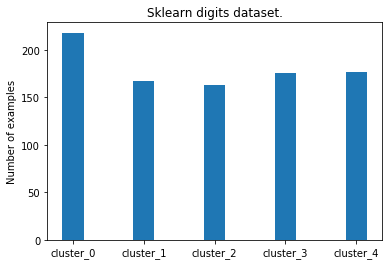

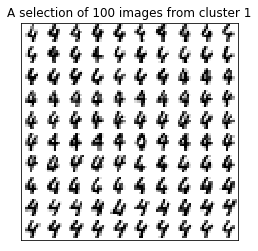

In [8]:
# Step 3: Use k-means to cluster your data and visualize your data
from sklearn.cluster import KMeans
num_clusters = 5
cluster_labels,centroids = kmeans(X, num_clusters)

labels = ["cluster_"+str(x) for x in range(num_clusters)]
population = [np.sum(cluster_labels==x) for x in range(num_clusters)]
y_pos = np.arange(len(labels))
barlist = plt.bar(y_pos, population, align='center',width=0.3)
plt.xticks(y_pos, labels)
plt.ylabel('Number of examples')
plt.title('Sklearn digits dataset.')
plt.show()

# display some images from the selected cluster
selected_cluster = 1
X_cluster_1 = X[cluster_labels == selected_cluster]
n_img_per_row = 10
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img_indx = i * n_img_per_row + j
        if img_indx < len(X_cluster_1):
            img[ix:ix + 8, iy:iy + 8] = X_cluster_1[i * n_img_per_row + j].reshape((8, 8))

plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('A selection of 100 images from cluster {:}'.format(selected_cluster))
plt.show()